In [87]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [88]:
test_directory = './data/mars/test/data/'
test_files = []

for filename in os.listdir(test_directory):
    if filename.endswith('.csv'):
        test_files.append(filename)

WINDOW_SIZE = 2000
STEP_SIZE = 30
MEAN_AMPLITUDE_FACTOR = 1.1
MAX_AMPLITUDE_DEVIATION = 80

In [89]:
# Power, bandwidth, spectral entropy, peak frequency, dominant frequency, centroid frequency, mean frequency and spectral amplitude

def get_power(dataframe):
    # The power of a signal is the sum of the squares of the absolute values of the signal's time-domain samples divided by the signal length
    data = dataframe.data

    return np.sum(np.abs(data)**2)

def get_bandwidth(dataframe):
    # The bandwidth of a signal is the range of frequencies that it contains
    data = dataframe.data
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft)**2)

def get_highest_amplitude(dataframe):
    data = dataframe.data

    return np.max(np.abs(data))

def get_lowest_amplitude(dataframe):
    data = dataframe.data

    return np.min(np.abs(data))

def get_spectral_entropy(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)
    power = np.abs(fft)**2
    power = power / np.sum(power)  # Normalización
    power = power[power > 0]  # Evitar log(0)

    return -np.sum(power * np.log(power))

def get_spectral_amplitude(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)

    return np.max(np.abs(fft))

def get_mean_amplitude(dataframe):
    data = dataframe.data

    return np.mean(np.abs(data))

def get_characteristics(dataframe):
    return dict(
        # power=get_power(dataframe),
        # bandwidth=get_bandwidth(dataframe),
        mean_amplitude=get_mean_amplitude(dataframe),
        # spectral_entropy=get_spectral_entropy(dataframe),
        spectral_amplitude=get_spectral_amplitude(dataframe)
    )

def get_file_data(file: str):
    data = pd.read_csv(file)

    csv_times = np.array(data['time_rel(sec)'].tolist())
    csv_data = np.array(data['velocity(c/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_file_data_from_catalog(index: int):
    filename = test_files[index]

    csv_file = f'{test_directory}{filename}'
    data_cat = pd.read_csv(csv_file)

    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(c/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_windowed_data(dataframe, offset=0, window_size=WINDOW_SIZE):
    result = []
    data = dataframe.data
    times = dataframe.time

    for i in range(offset, offset + window_size):
        if i >= len(data):
            break

        row = dict(
            time=times[i],
            data=data[i]
        )
        result.append(row)
    
    return pd.DataFrame(result)

def get_windows_characteristics(windows):
    characteristics = []

    for i in range(len(windows)):
        window = windows[i]

        characteristics.append(get_characteristics(window))
        print(f'Processed window {i}/{len(windows)}')

    return pd.DataFrame(characteristics)

def get_start_event_window(dataframe):
    max_spectral_amplitude = float('-inf')
    max_spectral_amplitude_index = 0

    dataframe_mean_amplitude = get_characteristics(dataframe)['mean_amplitude']

    for offset in range(0, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, offset)
        characteristics = get_characteristics(window)

        if characteristics['spectral_amplitude'] > max_spectral_amplitude:
            min_max_amplitude_difference = np.abs(get_highest_amplitude(window) - get_lowest_amplitude(window))
            deviation_coefficient =  min_max_amplitude_difference / dataframe_mean_amplitude

            if deviation_coefficient > MAX_AMPLITUDE_DEVIATION:
                continue

            max_spectral_amplitude = characteristics['spectral_amplitude']
            max_spectral_amplitude_index = offset
    
    # Go back 1 windows to get the start of the event
    max_spectral_amplitude_index -= 2 * STEP_SIZE
    
    return get_windowed_data(dataframe, max_spectral_amplitude_index), max_spectral_amplitude_index

def get_end_event_window(dataframe, event_window_index):
    # Starting in the event time, get the first window that its mean amplitude is less than the mean amplitude of the event window

    window_mean_amplitude = get_characteristics(dataframe)['mean_amplitude'] * MEAN_AMPLITUDE_FACTOR

    for i in range(event_window_index, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, i, WINDOW_SIZE)
        mean_amplitude = get_mean_amplitude(window)

        if mean_amplitude < window_mean_amplitude:
            return window, i

    return None, None

def get_event_dataframe(dataframe):
    _, start_event_window_index = get_start_event_window(dataframe)
    _, end_event_window_index = get_end_event_window(dataframe, start_event_window_index)

    result = dataframe.iloc[start_event_window_index:end_event_window_index]

    return result

def get_noiseless_data_from_file(file: str):
    data = get_file_data(file)

    return get_event_dataframe(data)

def remove_noise_from_file(file: str):
    data = get_file_data(file)
    event_data = get_event_dataframe(data)
    final_file = file.split('/')[-1]

    detect_df = pd.DataFrame(data = {
        "filename": [final_file for _ in range(len(event_data))],
        "time_rel(sec)": event_data.time,
        "velocity(c/s)": event_data.data
    })

    detect_df.to_csv(file.replace('.csv', '_NOISELESS.csv'), index=False)

In [90]:
def plot_test(index):
    file_index = index
    dataframe = get_file_data_from_catalog(file_index)

    start_event_window, start_event_window_index = get_start_event_window(dataframe)
    end_event_window, end_event_window_index = get_end_event_window(dataframe, start_event_window_index)

    print(f'Start event window: {start_event_window_index}')
    print(f'End event window: {end_event_window_index}')
    times = dataframe.time
    data = dataframe.data

    # plot
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(times, data)

    event_mean_amplitude = get_mean_amplitude(end_event_window)
    event_start_time = start_event_window.time.iloc[0]
    event_end_time = end_event_window.time.iloc[0]

    # Shadow the event window
    ax.axvspan(event_start_time, event_end_time, color='green', alpha=0.5)

    # Plot event mean amplitude
    ax.axhline(event_mean_amplitude, color='r', linestyle='--', label=f'Event mean amplitude ({event_mean_amplitude:.2f})')

    # Make the plot pretty
    ax.set_xlim([min(times), max(times)])
    ax.set_ylabel('Velocity (c/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'File index {index}', fontweight='bold')


    # Plot where the event window is
    event_window_times = dataframe.time[start_event_window_index:end_event_window_index]
    event_window_data = dataframe.data[start_event_window_index:end_event_window_index]
    event_window_line = ax.plot(event_window_times, event_window_data, c='purple', label=f'Event window (mean amplitude: {event_mean_amplitude:.2f})')
    ax.legend(handles=event_window_line)

    plt.show()

Start event window: 44610
End event window: 46020


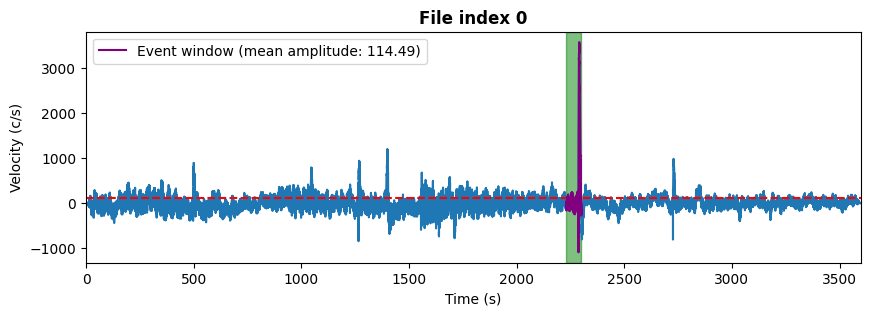

Start event window: 13710
End event window: 15300


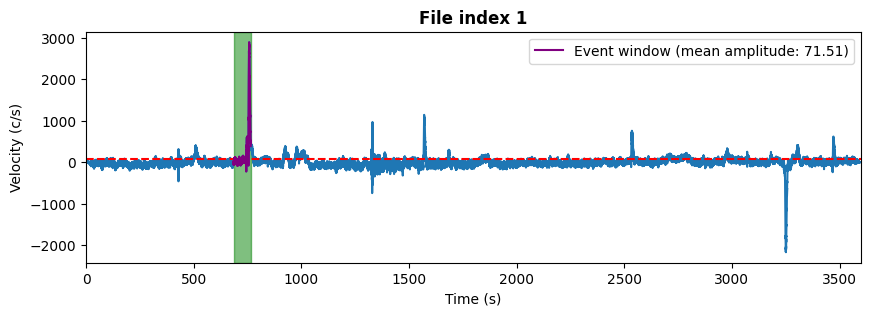

Start event window: 13710
End event window: 15300


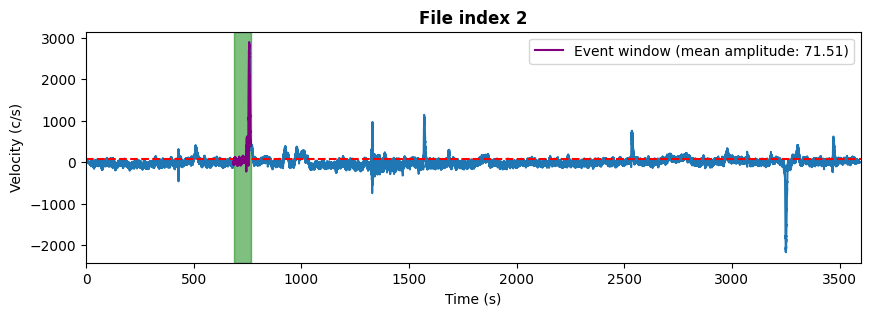

Start event window: 44310
End event window: 49200


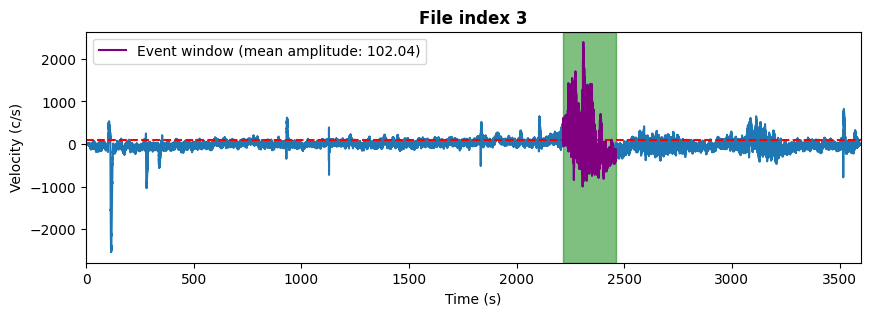

Start event window: 69300
End event window: 70890


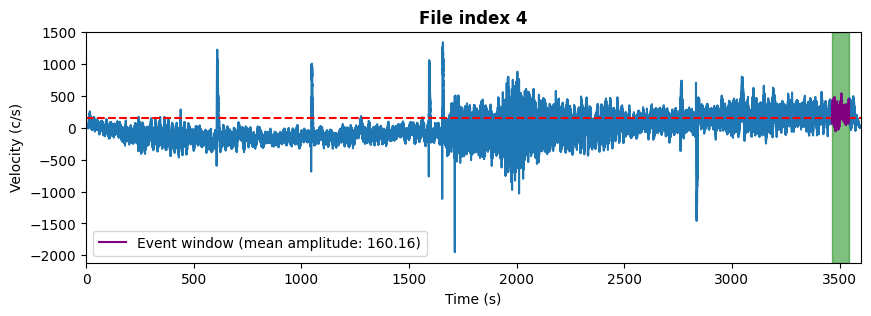

Start event window: 35790
End event window: 36720


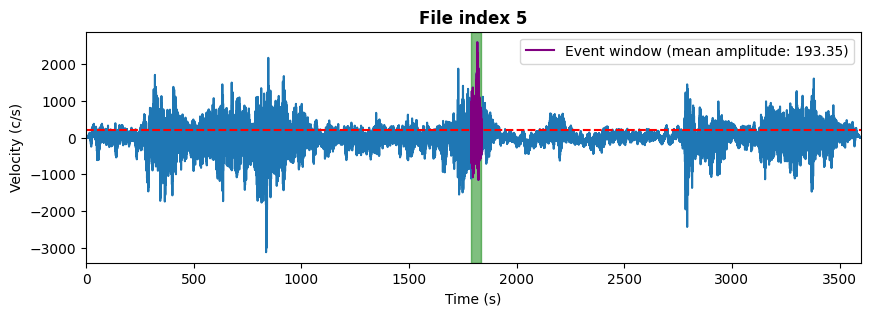

Start event window: 61560
End event window: 69810


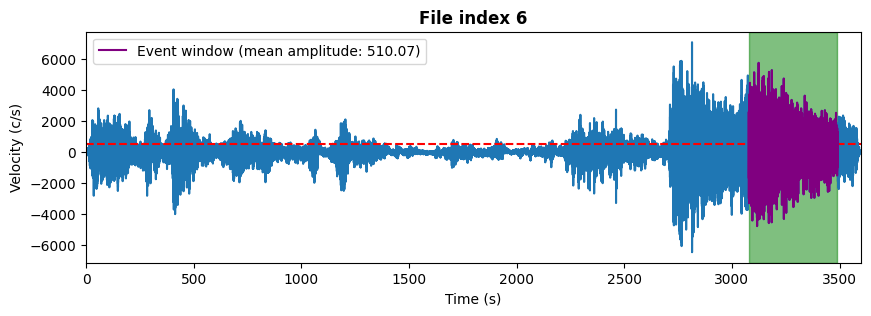

Start event window: 6180
End event window: 8130


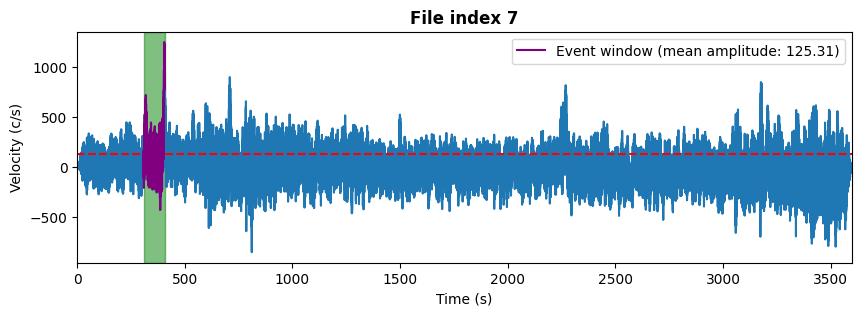

Start event window: 37440
End event window: 46890


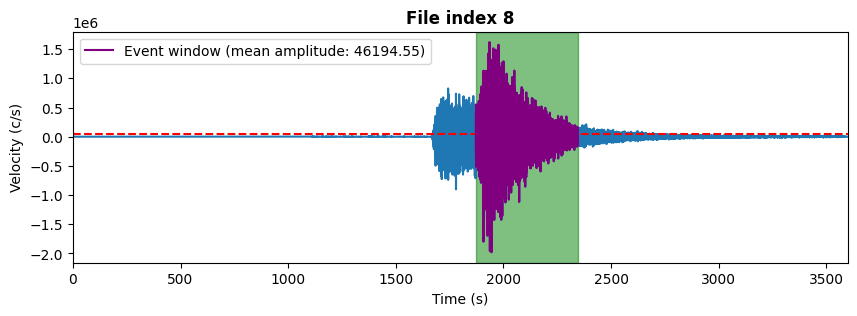

In [91]:
for n in range(0, len(test_files)):
    plot_test(n)

In [92]:
get_noiseless_data_from_file(f'./data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv')

,time,data
44610,2230.50,-38.387039
44611,2230.55,12.617777
44612,2230.60,33.622597
44613,2230.65,5.627417
44614,2230.70,23.632236
...,...,...
46015,2300.75,-256.615631
46016,2300.80,-177.610809
46017,2300.85,-163.605988
46018,2300.90,-232.601166
